<a href="https://colab.research.google.com/github/Harshavalmiki/258-Deep-learning/blob/main/A5_pt4_PyTorch_Lightning_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 05 Part D - PyTorch Lightning Version

create a 3 layer neural network.
use einsum.

Colab  pytorch lightening version of the same 3-layer deep neural network for non-linear regression.



### References Used
a. [deep_learning_fundamentals_part1.ipynb](https://colab.research.google.com/drive/1HS3qbHArkqFlImT2KnF5pcMCz7ueHNvY?usp=sharing&authuser=1#scrollTo=EGkS6nN6dQaz)

b. [TensorFlow 2.0 + Keras Crash Course.ipynb](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO?authuser=1#scrollTo=KC5RgwGeBP-9)

In [1]:
!pip install -q torch --upgrade
!pip install -q torchvision
!pip install -q pytorch-lightning --upgrade
!pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.3.0 which is incompatible.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.3.0 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.3.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.3.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 729.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Generate synthetic data
def generate_data(num_samples):
    x1 = np.random.rand(num_samples)
    x2 = np.random.rand(num_samples)
    x3 = np.random.rand(num_samples)
    y = np.sin(2 * np.pi * x1) + np.cos(2 * np.pi * x2) + np.tanh(2 * np.pi * x3)
    return x1, x2, x3, y

### NonLinearRegression Class

In [4]:
# Create a PyTorch Lightning module for the 3-layer neural network
class NonLinearRegression(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(NonLinearRegression, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.einsum('ij,bj->bi', self.hidden1.weight, x) + self.hidden1.bias
        x = torch.relu(x)
        x = torch.einsum('ij,bj->bi', self.hidden2.weight, x) + self.hidden2.bias
        x = torch.relu(x)
        x = torch.einsum('ij,bj->bi', self.output.weight, x) + self.output.bias
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)


### SyntheticDataModule Class

In [5]:
# Create a PyTorch Lightning data module
class SyntheticDataModule(pl.LightningDataModule):
    def __init__(self, x_data, y_data, batch_size):
        super(SyntheticDataModule, self).__init__()
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size

    def train_dataloader(self):
        dataset = torch.utils.data.TensorDataset(self.x_data, self.y_data)
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size)

###Convert to PyTorch Tensors

In [6]:
# Set the number of samples and generate synthetic data
num_samples = 1000
x1, x2, x3, y = generate_data(num_samples)

# Convert data to PyTorch tensors
x_data = torch.tensor(np.stack((x1, x2, x3), axis=1), dtype=torch.float32)
y_data = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

###Hyperparameters

In [7]:
# Set hyperparameters
input_size = 3
hidden_size = 64
output_size = 1
batch_size = 32
num_epochs = 100

In [9]:
# Create an instance of the neural network and data module
model = NonLinearRegression(input_size, hidden_size, output_size)
data_module = SyntheticDataModule(x_data, y_data, batch_size)

### Train

In [10]:
# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=num_epochs)

# Train the model
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | hidden1 | Linear | 256   
1 | hidden2 | Linear | 4.2 K 
2 | output  | Linear | 65    
-----------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### Generate Predictions

In [11]:
# Generate predictions
with torch.no_grad():
    y_pred = model(x_data).numpy()

## Plotting Results

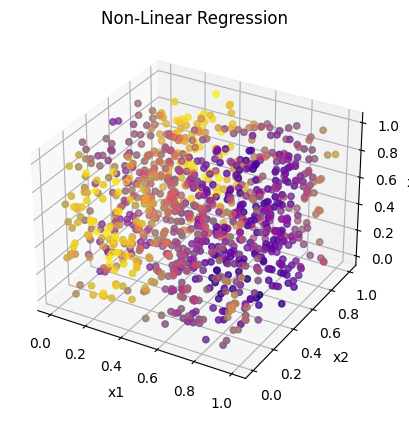

In [12]:
# Plot the results in a 4D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3, c=y, cmap='viridis')
ax.scatter(x1, x2, x3, c=y_pred, cmap='plasma', alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Non-Linear Regression')
plt.show()